<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/resnet_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title download
# original 10k
# # https://drive.google.com/file/d/1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q/view?usp=sharing
# !gdown 1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q -O gsv.zip
# !unzip /content/gsv.zip -d /content
# import shutil
# shutil.rmtree('/content/google_street_view/meta_data', ignore_errors=True) # delete the meta_data folder

# # clip cleaned
# # https://drive.google.com/file/d/1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB/view?usp=share_link
# !gdown 1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB -O gsv.zip
# !unzip /content/gsv.zip -d /
# !rm -R /content/gsv/.ipynb_checkpoints
# !rm -R /content/gsv/01/.ipynb_checkpoints
# !rm -R /content/gsv/02/.ipynb_checkpoints
# !rm -R /content/gsv/03/.ipynb_checkpoints
# !rm -R /content/gsv/04/.ipynb_checkpoints
# !rm -R /content/gsv/05/.ipynb_checkpoints
# !rm -R /content/gsv/06/.ipynb_checkpoints

# # gsv 70k
# # https://drive.google.com/file/d/1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8/view?usp=share_link
# !gdown 1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8 -O gsv.zip
# !unzip /content/gsv.zip -d /

# # # !ls
# !ls -a /content/gsv70k
# !rm -R /content/gsv70k/.ipynb_checkpoints
# # # !rm -R /content/gsv/06/.ipynb_checkpoints

# # 70k+gmap
# # https://drive.google.com/file/d/1-CZp7TbhJLeRQpbKQCyT8ofGg89Yt137/view?usp=sharing
!gdown 1-CZp7TbhJLeRQpbKQCyT8ofGg89Yt137 -O gsv.zip
!unzip /content/gsv.zip -d /
!rm -R /content/gsv70kg/.ipynb_checkpoints
!rm -R /content/gsv70kg/01/.ipynb_checkpoints
!rm -R /content/gsv70kg/02/.ipynb_checkpoints
!rm -R /content/gsv70kg/03/.ipynb_checkpoints
!rm -R /content/gsv70kg/04/.ipynb_checkpoints
!rm -R /content/gsv70kg/05/.ipynb_checkpoints
!rm -R /content/gsv70kg/06/.ipynb_checkpoints

# # https://bestasoff.medium.com/how-to-fine-tune-very-large-model-if-it-doesnt-fit-on-your-gpu-3561e50859af
!pip install bitsandbytes


In [2]:
# @title torch augment
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py
import torch
import torchvision.transforms as transforms

class TrainTransform(object):
    def __init__(self):
        # self.transform = transforms.RandomApply([transforms.Compose([
        self.transform = transforms.Compose([
                transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                transforms.RandomResizedCrop((400,640), scale=(0.7, 1.0), ratio=(0.8, 1.25), interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5), # 0.5
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,), # brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8
                transforms.RandomGrayscale(p=0.2), # 0.2
                # transforms.RandomChoice(transforms.ColorJitter , transforms.RandomGrayscale(p=1.)
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=1.0),
                # transforms.RandomSolarize(threshold=130, p=0.5)
                # transforms.RandomErasing(p=0.5, scale=(0.1, 0.11), ratio=(1,1), value=0, inplace=True), # default p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False
                transforms.RandomErasing(p=1., scale=(0.1, 0.11), ratio=(1,1), value=0., inplace=True), # default p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False
                # transforms.ToTensor(), # ToTensored at dataset level, no need to ToTensor again
                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalised at dataset level. default 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225
                ])
            # ], p=1.)

    def __call__(self, sample):
        # dims = len(sample.shape)
        # if dims==3: x1 = self.transform(sample) # same transforms per minibatch
        # elif dims==4: x1 = transforms.Lambda(lambda x: torch.stack([self.transform(x_) for x_ in x]))(sample) # diff transforms per img in minibatch
        x1 = self.transform(sample)
        return x1

trs=TrainTransform()


In [ ]:
# print(nan)
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

trs=TrainTransform() # for image augmentation during train time
# train function with automatic mixed precision
# def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
size = len(train_loader.dataset)
model.train()
loss_list = []
c=0
for batch, (x, y) in enumerate(train_loader):
    print("##############", batch)
    x, y = x.to(device), y.to(device)
    with torch.cuda.amp.autocast(): # automatic mixed percision
        print("1: ",x)
        x = trs(x) # image augmentation during train time to use gpu
        print("2: ",x)
        # pred = model(x) # default
        modules = [module for k, module in model._modules.items()]
        pred = checkpoint_sequential(functions=modules, segments=1, input=x) # gradient checkpointing for resnet and inception only
        # # pred = checkpoint_sequential(functions=model.mods, segments=1, input=x)
        print("train",pred[0])

        print((pred.argmax(1)==y).sum().item(), pred.argmax(1).tolist(), y.tolist())
        loss = loss_fn(pred, y)
    scaler.scale(loss).backward()
    if ((batch + 1) % 4 == 0) or (batch + 1 == len(train_loader)): # gradient accumulation
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        # if scheduler is not None:
        #     scheduler.step()
        #     print("### lr: ", optimizer.param_groups[0]["lr"])

    print(model.state_dict()['_orig_mod.bn1.running_mean'][0])

    c+=1
    if c>3: break



############## 0
1:  tensor([[[[-0.3712, -0.3541, -0.3541,  ...,  0.3994,  0.3994,  0.3994],
          [-0.3198, -0.3198, -0.3198,  ...,  0.3994,  0.3994,  0.3994],
          [-0.2856, -0.2856, -0.2856,  ...,  0.3994,  0.3994,  0.3994],
          ...,
          [ 1.4098,  1.3413,  1.3584,  ..., -1.0904, -1.2788, -1.2103],
          [ 1.3755,  1.4098,  1.4098,  ..., -1.5528, -1.3987, -1.4672],
          [ 1.4098,  1.5297,  1.5810,  ..., -1.3130, -1.3815, -1.3644]],

         [[ 0.5728,  0.5903,  0.5903,  ...,  1.2381,  1.2381,  1.2381],
          [ 0.6254,  0.6254,  0.6254,  ...,  1.2381,  1.2381,  1.2381],
          [ 0.6604,  0.6604,  0.6604,  ...,  1.2381,  1.2381,  1.2381],
          ...,
          [ 1.2731,  1.2031,  1.2031,  ..., -1.0028, -1.1954, -1.1253],
          [ 1.2381,  1.2556,  1.2556,  ..., -1.4755, -1.3179, -1.3880],
          [ 1.2731,  1.3782,  1.3782,  ..., -1.2304, -1.3004, -1.2829]],

         [[ 2.0125,  2.0300,  2.0300,  ...,  2.3437,  2.3437,  2.3437],
         

In [3]:
# @title data (old)
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dir='/content/gsv70kg'

data = datasets.ImageFolder(dir, transform=transform)
# data = datasets.ImageFolder(dir, transform=None)
torch.manual_seed(0)
train_data, test_data = torch.utils.data.random_split(data, [.9,.1])

batch_size = 16 # 64
num_batches=int(np.ceil(len(train_data)/batch_size))

# train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4, pin_memory=True)
del data, train_data, test_data



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# @title data weighted
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# transform = transforms.Compose(transforms.ToTensor())

# dir='/content/gsv'
dir='/content/gsv70kg'

# data = datasets.ImageFolder(dir, transform=transform)
data = datasets.ImageFolder(dir, transform=None)
torch.manual_seed(0)

# split data manually so that can work with weighted random sampler
# train_data, test_data = torch.utils.data.random_split(data, [.85,.15])
# https://www.scaler.com/topics/pytorch/how-to-split-a-torch-dataset/
data_size = len(data)
indices = np.arange(data_size)
np.random.shuffle(indices)
split_index = int(np.floor(0.9 * data_size))
# split_index = int(np.floor(0.002 * data_size))
train_idx, test_idx = indices[:split_index], indices[split_index:]
# train_idx, test_idx = indices[:split_index], indices[split_index:split_index*2]
# train_idx, test_idx = indices[:145], indices[10000:10017]
train_data = torch.utils.data.Subset(data, train_idx)
test_data = torch.utils.data.Subset(data, test_idx)
targets = np.array(data.targets)
train_targets = targets[train_idx]
test_targets = targets[test_idx]


from torch.utils.data import Dataset
class DatasetWrap(Dataset):
    def __init__(self, dataset, transform=None):
        super(DatasetWrap, self).__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

# dataset wrapper in order to apply transforms to train data only
# train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
train_data = DatasetWrap(train_data, transform) # apply transform during training to use gpu
test_data = DatasetWrap(test_data, transform)

# use batch size 16 for resnet 152/ vit with grad accumulation
# can use batch size 64 for inception v3 without grad accumulation?
batch_size = 16 # 64/16
num_batches=int(np.ceil(len(train_data)/batch_size))

# oversampling
# https://stackoverflow.com/questions/62319228/number-of-instances-per-class-in-pytorch-dataset
from collections import Counter
class_count = torch.tensor(list(Counter(data.targets).values()))
weights=1./class_count
# weights=sum(class_count)/class_count
# print(weights)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler

train_weight = weights[train_targets]
test_weight = weights[test_targets]
train_sampler = torch.utils.data.WeightedRandomSampler(train_weight, len(train_weight))
test_sampler = torch.utils.data.WeightedRandomSampler(test_weight, len(test_weight))
# train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True, drop_last=True)
# test_loader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4, pin_memory=True, drop_last=True)
del data, train_data, test_data


# test oversampling: occurence of each class should be roughly equal
# c=0
# print(len(test_loader))
# # for batch, (x, y) in enumerate(train_loader):
# for batch, (x, y) in enumerate(test_loader):
#     print(torch.bincount(y)) # torch count number of elements with value in tensor
#     c+=1
#     if c>5: break

# display img from torch tensor
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# images=trs(images)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# del dataiter

# print(labels)

# dataiter = iter(test_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# del dataiter


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models
# # https://pytorch.org/vision/0.12/models.html#id10
model = models.resnet152(weights='DEFAULT') # 18 34 50 101 152
num_ftrs = model.fc.in_features
model.fc = nn.Sequential( # og (fc): Linear(in_features=2048, out_features=1000, bias=True)
    nn.Linear(num_ftrs, 6),
    nn.Softmax(dim=1),
    )

def track_false(m):
    if isinstance(m, nn.BatchNorm2d):
        m.track_running_stats = False
model.apply(track_false)

# print(model)

# # model.mods = [module for k, module in model._modules.items()]
# # modules = [module for k, module in model._modules.items()]

# torch._dynamo.config.suppress_errors = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
model = torch.compile(model.to(device),mode='max-autotune')

# resnet152 batch16 compile gradacc nogradckpt lr3e-6,3e-5


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:03<00:00, 67.6MB/s]


In [ ]:
# @title vit
# https://arxiv.org/pdf/2010.11929.pdf
import torch
import torch.nn as nn
from torchvision import models
# https://pytorch.org/vision/main/models/vision_transformer.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16
# model = models.vit_l_16(weights='DEFAULT') # small vit_b_16 vit_b_32 vit_l_16 vit_l_32 vit_h_14 big
# # VisionTransformer(image_size, patch_size, num_layers, num_heads, hidden_dim, mlp_dim)
# num_ftrs = model.heads.head.in_features
# # num_ftrs = model.heads[-1].in_features
# model.heads = nn.Sequential(
#     # nn.Dropout(0.2),
#     nn.Linear(num_ftrs, 6, bias=False),
#     nn.Softmax(dim=1),
#     )


!pip install timm
# https://github.com/huggingface/pytorch-image-models/issues/908
import timm
# model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = timm.create_model('vit_base_patch16_224', img_size=(400, 640), pretrained=True)
# [print(x) for x in timm.list_models('vit*',pretrained=True)]
# https://huggingface.co/google/vit-base-patch16-224
# https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
# vit_base_patch16_224 compile,no ckpt # patch_size=16, embed_dim=768, depth=12, num_heads=12
# vit_base_patch16_384
# vit_large_patch16_224 explodesgpu # patch_size=16, embed_dim=1024, depth=24, num_heads=16
# vit_large_patch16_384 # patch_size=16, embed_dim=1024, depth=24, num_heads=16

# or fine tune huge
# vit_large_patch14_224 # patch_size=16, embed_dim=1024, depth=24, num_heads=16
# vit_large_patch16_384


num_ftrs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(num_ftrs, 6),
    nn.Softmax(dim=1),
    )
# model.set_grad_checkpointing()

# print(model.patch_embed.grid_size) # (25, 40)
# print(model.pos_embed.shape) # [1, 1001, 768]
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

# print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
# model = torch.compile(model.to(device),mode='max-autotune')

# vit_base_patch16_224 batch16 maxcompile nockpt gradacc lr1e-5,1e-4


In [ ]:
# @title inception
import torch
import torch.nn as nn
from torchvision import models
# # https://pytorch.org/vision/0.12/models.html#id10
model = models.inception_v3(pretrained=True)
# https://discuss.pytorch.org/t/inception-v3-is-not-working-very-well/38296/16
# https://colab.research.google.com/github/CaoCharles/Deep-Learning-with-PyTorch/blob/master/2_Inception.ipynb
model.aux_logits = False
num_ftrs = model.fc.in_features # 2048
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 6), # og: (fc): Linear(in_features=2048, out_features=1000, bias=True)
    # nn.Linear(num_ftrs, 128), nn.ReLU(), nn.Linear(128, 6),
    nn.Softmax(dim=1),
    )
# pytorch "inception" v3 "gradient checkpointing" https://github.com/jianweif/OptimalGradCheckpointing

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='max-autotune')

# inception batch64 compile nogradacc nogradckpt lr3e-6,3e-5


In [ ]:
# @title try

# # check model's input and output dimensions are correct
# X = torch.rand(64, 3, 32, 32, device=device)
X = torch.rand(16, 3, 400, 640, device=device)
# X = torch.rand(16, 3, 224, 224, device=device)
model.eval()

# 224x224
# 16x16 / 32x32 patch
# -> 14x14=196 7x7=49 seq length
# 400x640 -> 25x40=1000 seq length


logits = model(X)

# modules = [module for k, module in model._modules.items()]
# for i,x in enumerate(modules):
#     print(i,x)

# logits = checkpoint_sequential(functions=modules, segments=1, input=X)

print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))

pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(y_pred)
del X, logits


torch.Size([16, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [5]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()
# https://github.com/prigoyal/pytorch_memonger/blob/master/models/optimized/resnet_new.py
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

trs=TrainTransform() # for image augmentation during train time
# train function with automatic mixed precision
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(): # automatic mixed percision
            x = trs(x) # image augmentation during train time to use gpu
            # pred = model(x) # default
            modules = [module for k, module in model._modules.items()]
            pred = checkpoint_sequential(functions=modules, segments=1, input=x) # gradient checkpointing for resnet and inception only
            # # pred = checkpoint_sequential(functions=model.mods, segments=1, input=x)
            print("train",pred[0])
            print((pred.argmax(1)==y).sum().item(), pred.argmax(1).tolist(), y.tolist())
            loss = loss_fn(pred, y)
        scaler.scale(loss).backward()
        if ((batch + 1) % 4 == 0) or (batch + 1 == len(dataloader)): # gradient accumulation
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            if scheduler is not None:
                scheduler.step()
                print("### lr: ", optimizer.param_groups[0]["lr"])

        print(model.state_dict()['_orig_mod.bn1.running_mean'][0])
        loss_list.append(loss.item())
        # if (batch) % (size//(10* len(x))) == 0:
        # loss, current = loss.item(), batch * len(x)
        loss, current = loss.item()/len(y), batch * len(x)
        if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            print(pred[0])
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            print((pred.argmax(1)==y).sum().item(), pred.argmax(1).tolist(), y.tolist())
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # should not use weighted rand sampler for test?
    if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss


In [ ]:
# @title Lamb
# https://github.com/cybertronai/pytorch-lamb/blob/master/pytorch_lamb/lamb.py
import torch
from torch.optim import Optimizer

class Lamb(Optimizer):
    """Large Batch Optimization for Deep Learning: Training BERT in 76 minutes: https://arxiv.org/abs/1904.00962
        adam (bool, optional): always use trust ratio = 1, which turns this into Adam"""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=0, adam=False): # eps=1e-8, weight_decay=0
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.adam = adam
        super(Lamb, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None: loss = closure() # closure (callable, optional): A closure that reevaluates the model and returns the loss.
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.is_sparse: raise RuntimeError('Lamb does not support sparse gradients, consider SparseAdam instad.')
                state = self.state[p] # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data) # Exponential moving average of gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data) # Exponential moving average of squared gradient values
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1) # m_t
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2) # v_t

                # Paper v3 does not use debiasing.
                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']
                # Apply bias to lr to avoid broadcast.
                step_size = group['lr'] # * math.sqrt(bias_correction2) / bias_correction1
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                adam_step = exp_avg / exp_avg_sq.sqrt().add(group['eps'])
                if group['weight_decay'] != 0: adam_step.add_(p.data, alpha=group['weight_decay'])
                adam_norm = adam_step.pow(2).sum().sqrt()
                if weight_norm == 0 or adam_norm == 0: trust_ratio = 1
                else: trust_ratio = weight_norm / adam_norm
                state['weight_norm'] = weight_norm
                state['adam_norm'] = adam_norm
                state['trust_ratio'] = trust_ratio
                if self.adam: trust_ratio = 1
                p.data.add_(adam_step, alpha=-step_size * trust_ratio)
        return loss


In [ ]:
# @title LR range test
# gives insight into good LR range to use.
# for accurate results, be sure to use a new model for range test;
# also reset the model before training bec range test destroys the model
# 1cycle super convergencehttps://arxiv.org/pdf/1708.07120.pdf
# # cyclic lr https://arxiv.org/pdf/1506.01186.pdf
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall

# one training run of the network for a few epochs
# pth='/content/lr.pth'
# torch.save(model.state_dict(), pth) # save temporary model for lr finding
# model.load_state_dict(torch.load("lr.pth"))
# torch.autograd.set_detect_anomaly(True)
epochs=1
min_lr= 1e-6
max_lr= 1e-1 # 1e-2
# 152: 1e-7 - 1e-4      result 3e-7 - 3e-6
# inception: 1e-7 - 1e1      result 3e-7 - 3e-6

loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)
# import bitsandbytes as bnb
# optimizer = bnb.optim.AdamW(model.parameters(), lr=min_lr, betas=(0.9, 0.999), optim_bits=8)
optimizer = Lamb(model.parameters(), lr=min_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)

num_batches=len(test_loader)
# num_batches=len(train_loader)

# total_steps=int(num_batches*epochs)
total_steps=int(np.ceil(num_batches/4)*epochs) # for grad accumulation

# min_lr* gamma^total_steps = max_lr
gamma = np.exp(np.log(max_lr/min_lr)/total_steps)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)

total_steps=total_steps*4 # for grad accumulation
gamma = np.exp(np.log(max_lr/min_lr)/total_steps)
lr_list=np.ones(total_steps)*min_lr*gamma**np.arange(total_steps)
train_lst, test_lst=[],[]


print("lr: ", optimizer.param_groups[0]["lr"])
for i in range(epochs):
    train_ls = strain(test_loader, model, loss_fn, optimizer, scheduler)
    # train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    train_lst.extend(train_ls)
print(optimizer.param_groups[0]["lr"])

# https://stackoverflow.com/a/53472966/13359815
from scipy.ndimage.filters import gaussian_filter1d
train_lstsm = gaussian_filter1d(train_lst, sigma=30)

import matplotlib.pyplot as plt
plt.plot(lr_list, train_lst)
plt.plot(lr_list, train_lstsm)
plt.xscale('log')
# plt.plot(train_lst)
# plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.close()


In [14]:
# @title wwwwwwwww
acc_lst, train_lst, test_lst=[],[],[]
loss_fn = nn.CrossEntropyLoss()

base_lr, max_lr = 3e-7, 3e-6 # resnet
# base_lr, max_lr = 1e-3, 1e-2 # resnet lamb
# base_lr, max_lr = 1e-6, 1e-5 # vit
# base_lr, max_lr = 3e-6, 3e-5 # inception
# end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1
tp=0
epochs = 5 #5 20
# optimizer = torch.optim.SGD(model.parameters(), lr = start_lr, momentum=0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
import bitsandbytes as bnb # 8bit optimizer
optimizer = bnb.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), optim_bits=8)
# optimizer = bnb.optim.AdamW(model.parameters(), lr=3e-6, betas=(0.9, 0.999), optim_bits=8)
# optimizer = Lamb(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# optimizer = Lamb(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# 152 1e-5
# cnn 3e-4

div_factor = max_lr/base_lr
num_batches=len(train_loader)
# total_steps=int(num_batches*epochs)+1 # +1 to excluse uptick at the end of onecycle
total_steps=int(np.ceil(num_batches/4)*epochs +1) # /4 for when using grad accumulation
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=100.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# gamma = np.exp(np.log(end_lr/start_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)

# pth='/content/res15270kg.pth'
# pth='/content/res15270kg05aug.pth' # sps
# pth='/content/drive/MyDrive/frame/res15236.pth' # B
# pth='/content/drive/MyDrive/frame/res152373605aug.pth' # B
# pth='/content/drive/MyDrive/frame/res152lamb12.pth' # sps
# pth='/content/res152lamb12.pth' # sps
# pth='/content/drive/MyDrive/frame/res15270kold.pth' # M
pth='/content/drive/MyDrive/frame/res152trackf.pth' # B


# pth='/content/vit.pth'
# pth='/content/drive/MyDrive/frame/vit.pth'
# pth='/content/drive/MyDrive/frame/vit3736.pth'
# pth='/content/drive/MyDrive/frame/vit161505aug.pth' # A

# pth='/content/drive/MyDrive/frame/inception1.pth'
# pth='/content/drive/MyDrive/frame/inception363505aug.pth' # ty


# # to continue training
# tp, modelsd, optimsd, schedsd = torch.load(pth).values()
# # tp, modelsd, optimsd = torch.load(pth).values()
# model.load_state_dict(modelsd)
# optimizer.load_state_dict(optimsd)
# scheduler.load_state_dict(schedsd)



In [15]:
# @title save
from google.colab import drive
drive.mount('/content/drive')

# # pth='/content/drive/MyDrive/frame/vit.pth'
# pth='/content/drive/MyDrive/frame/res55.pth'
# pth='/content/drive/MyDrive/frame/resnet152.pth'
# pth='/content/drive/MyDrive/frame/res152373605aug.pth'
# pth='/content/res152373605aug.pth' # B
# pth='/content/drive/MyDrive/frame/res152lamb12.pth' # ty
# pth='/content/drive/MyDrive/frame/res1522.pth' # A
# pth='/content/drive/MyDrive/frame/res1522do.pth' # A

# pth='/content/drive/MyDrive/frame/inception.pth'
# pth='/content/inception2.pth'

# pth='/content/res15270kg.pth'

# pth='/content/drive/MyDrive/frame/vit3736.pth'


# tp, modelsd, optimsd, schedsd = torch.load(pth).values()
# model.load_state_dict(modelsd)
# # optimizer.load_state_dict(optimsd)
# # scheduler.load_state_dict(schedsd)


# checkpoint = { # https://discuss.pytorch.org/t/saving-model-and-optimiser-and-scheduler/52030
# 'epoch': t+1,
# 'model': model.state_dict(),
# 'optimizer': optimizer.state_dict(),
# # # 'lr_sched': scheduler.state_dict()
# }
# torch.save(checkpoint, pth)



# pth='/content/model.pth'
# torch.save(model.state_dict(), pth)
# model.load_state_dict(torch.load(pth))
# # model.load_state_dict(torch.load("model.pth"))

# !gdown 1---4fdFbOUBTrS-VP5Va6pKowfgoU2UN -O inception2.pth
# !gdown 1visTNvWmnuV7jAm2TBiAIIrNjbOAi1Fv -O resnet152.pth
# !gdown 1vszqD7O9hju9-iWm4WkDPZ_adHY1j2rw -O res152373605aug.pth # A
# !gdown 1IDQLTn6yisr47-ronpJGfEmi2-lhAcve -O res152373605aug.pth # S
# !gdown 1-3oA1cKxgw4cfrqx079h_MKtMqRT1UFq -O res152lamb12.pth # S



# # t, modelsd, optimsd, scheduler = torch.load('/content/drive/MyDrive/frame/resnet152.pth').values()
# t, modelsd, optimsd, scheduler = torch.load('/content/resnet152.pth').values()
# model.load_state_dict(modelsd)
# # optimizer.load_state_dict(optimsd)

# # matt152 # https://drive.google.com/file/d/1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J/view?usp=sharing
# !gdown 1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J -O res152.pth
# model.load_state_dict(torch.load("res152.pth"))


Mounted at /content/drive


In [ ]:
# @title reset batchnorm
# print(model.state_dict()['_orig_mod.bn1.running_mean'][0])

def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()

# model.apply(deactivate_batchnorm)


In [ ]:

import time
start = time.time()

# scheduler = PolynomialLR(optimizer, total_iters=4, power=1.0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10**(-1/2))
# for epoch in range(5):
#     scheduler.step()
for t in range(tp,epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    print(lr)
    train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    # train_ls = strain(train_loader, model, loss_fn, optimizer)
    correct, test_loss = test(test_loader, model, loss_fn)
    train_lst.extend(train_ls)
    test_lst.append(test_loss)
    acc_lst.append(correct)

    # checkpoint = { # https://discuss.pytorch.org/t/saving-model-and-optimiser-and-scheduler/52030
    # 'epoch': t+1,
    # 'model': model.state_dict(),
    # 'optimizer': optimizer.state_dict(),
    # 'lr_sched': scheduler.state_dict()}
    # torch.save(checkpoint, pth)
    # # torch.save(model.state_dict(), pth)

# print("Done!")

# end = time.time()
# print("time: ",end - start)

# print(len(train_lst), len(test_lst))
# import matplotlib.pyplot as plt
# plt.plot(train_lst)
# plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
# plt.show()
# plt.plot(acc_lst)
# plt.show()
# plt.close()


# torch.save(model.state_dict(), "model.pth")

# resnet 18, 60/61 38.4%, 528s
# resnet 18, 58/61 39.8%, 523s
# resnet 18 compile , 58/61 40.4%, 555s
# resnet 18 compile augment , 58/61 36.4%, 1941 # augment on cpu, takes longer
# resnet 18 augment lr3e-4:3e-3, 58/61 37.7%, 1863s
# resnet 18 augment 10epoch lr1e-5:3e-4, 58/61 33.5%, 3387s
# resnet 18 compile lr1e-5:3e-4, 58/61 35.0%, 493s
# resnet 18 compile scratch lr1e-5:1e-3, 58/61 26.8%, 475s
# resnet 18 compile lr1e-5:1e-3, 55/61 47.3%, 480s
# resnet 18 compile lr1e-5:1e-3, 52/61 51.7% 503s
# resnet 18 compile lr1e-5:1e-3, unfreeze 51.0%, 550s
# resnet 18 compile lr1e-5:1e-4, unfreeze 52.7%, 518s
# resnet 34 compile lr1e-5:1e-4, unfreeze bitsadamW batch16*4
# resnet 152 compileoverhead lr3e-7:3e-6, bitsadamW batch16*4 ckpt 53.8%, 2066s
# resnet 152 from53.8% augment+cutout lr3e-7:3e-6, 53.8%, 2088s
# resnet 152 comile augment+cutout lr1e-5 /4 1epoch 48.3%, 454s
# resnet 152 comile augment+cutout lr1e-5 1epoch 48.4%, 446s
# resnet 152 comilemaxautotue augment+cutout lr1e-5 1epoch 47.7%, 448
# resnet 152 clipclean comilemax augment+cutout lr1e-5 10epoch 45.1%, 1585 *2
# resnet 152 clipclean comilemax augmax lr1e-6:3e-5 20epoch
# resnet 152 clipclean compilemax lr3e-7:1e-5,
# resnet 152 70k augment compilemax lr3e-7:3e-6 5epoch, 65.4% 11585s*5/3=19300s = 5h20m

# resnet 152 70k augment compile adamw const lr3e-6, 59.8%
# resnet 152 70k augment compile adamw const3e-6 stepdown



# resnet 152 70k augment compile lamb lr1e-2 not learning
# resnet 152 70k augment compile lamb lr3e-3 not learning
# resnet 152 70k augment compile lamb lr1e-3:1e-2 5epoch,
# 2/5epochwarmup 55.0%

# resnet 152 70kg augment1 cut1,-1 compilemax adamw lr3e-7:3e-6 1/5epoch 31.1% ty
# resnet 152 70k augment1 cut1,-1 compilemax adamw lr3e-7:3e-6 1/5epoch 28.1% A

# resnet 152 70k dataold augment1 cut1,0 compilemax adamw lr3e-7:3e-6 M nantest
# resnet 152 70kg augment1 cut1,0 compilemax adamw lr3e-7:3e-6 B





# vit b16 lr1e-5 5epochs 41.3%, 466s # 4.4ram, 5.5vram
# vit l16 lr1e-5 5epochs # 32.0%, 1242s 4.5ram, 8.0vram
# vit l16 lr3e-7;1e-5 5epochs # 45.4%, 1315s 4.5ram, 8.0vram
# vit l32 lr1e-5 5epochs # .ram, .vram
# vit_large_patch16_384
# vit_base_patch16_224 maxcompile nockpt lr3e-7;1e-5 5epochs # 45.2%, 2272s 5.3ram, 11.0vram
# vit_base_patch16_224 maxcompile nockpt gradacc batch16 1e-5, 1e-2 explode
# vit_base_patch16_224 maxcompile nockpt gradacc batch16 1e-6, 1e-5 low acc, test nan
# vit_base_patch16_224 maxcompile nockpt gradacc batch16 3e-7, 3e-6 4/5 epoch50%
# vit_base_patch16_224 maxcompile nockpt gradacc batch16 1e-6, 1e-5 0.5aug



# inception
# inception og 10kclean 1e-7, 3e-5 batch64 nockpt 5epochs 0.020348  51.4%, 0.024312 20m; 1st 40.5% max 52.1
# inception hid 10kclean 1e-7, 3e-5 batch64 nockpt 1/5epochs 0.019635 53.6%, 0.024120 1st 32.8%, max 53.6%
# inception og 10kclean 1e-7, 1e-4 batch64 nockpt 2/10epochs 0.020348  0.020923 39.9%, 0.026105
# inception og 70kg 1e-7 nope
# inception og 70kg 3e-6 3e-5 17%
# inception og 70kg 1e-6, 1e-5
# inception og 70kg 3e-6 3e-5 0.5aug





Epoch 1
-------------------------------
3.000000000000001e-07
train tensor([0.1752, 0.1661, 0.1747, 0.1680, 0.1646, 0.1515], device='cuda:0',
       grad_fn=<SelectBackward0>)
4 [0, 2, 1, 0, 2, 2, 2, 2, 1, 0, 4, 4, 2, 2, 2, 2] [2, 2, 3, 4, 1, 2, 4, 4, 0, 1, 3, 0, 3, 2, 2, 0]
tensor(-0.0045, device='cuda:0')
loss: 0.111788  [    0/61145]
train tensor([0.1689, 0.1687, 0.1829, 0.1650, 0.1629, 0.1517], device='cuda:0',
       grad_fn=<SelectBackward0>)
2 [2, 2, 1, 2, 2, 2, 0, 1, 1, 0, 1, 2, 2, 1, 2, 2] [0, 2, 0, 4, 3, 1, 5, 4, 4, 2, 2, 0, 3, 4, 3, 2]
tensor(-0.0045, device='cuda:0')
loss: 0.111931  [   16/61145]
train tensor([0.1930, 0.1793, 0.1614, 0.1638, 0.1518, 0.1506], device='cuda:0',
       grad_fn=<SelectBackward0>)
1 [0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2] [3, 0, 3, 2, 1, 3, 0, 2, 3, 0, 0, 3, 0, 3, 3, 3]
tensor(-0.0045, device='cuda:0')
loss: 0.111831  [   32/61145]
train tensor([0.1812, 0.1753, 0.1755, 0.1625, 0.1619, 0.1436], device='cuda:0',
       grad_fn=<SelectBackw

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


### lr:  3.000014406044184e-07
tensor(-0.0045, device='cuda:0')
loss: 0.111800  [   48/61145]
train tensor([0.1763, 0.1713, 0.1701, 0.1748, 0.1567, 0.1507], device='cuda:0',
       grad_fn=<SelectBackward0>)
7 [0, 2, 3, 1, 3, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2] [2, 0, 3, 3, 0, 3, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2]
tensor(-0.0045, device='cuda:0')
loss: 0.111608  [   64/61145]
train tensor([0.1801, 0.1570, 0.1927, 0.1683, 0.1504, 0.1515], device='cuda:0',
       grad_fn=<SelectBackward0>)
5 [2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0] [2, 2, 0, 1, 0, 1, 0, 4, 4, 4, 1, 0, 0, 0, 4, 0]
tensor(-0.0045, device='cuda:0')
loss: 0.111599  [   80/61145]
train tensor([0.1761, 0.1666, 0.1702, 0.1602, 0.1682, 0.1588], device='cuda:0',
       grad_fn=<SelectBackward0>)
1 [0, 1, 0, 2, 0, 0, 2, 1, 2, 0, 3, 2, 2, 0, 1, 1] [1, 2, 2, 0, 2, 3, 2, 0, 3, 2, 1, 3, 4, 1, 2, 3]
tensor(-0.0045, device='cuda:0')
loss: 0.111751  [   96/61145]
train tensor([0.1855, 0.1725, 0.1562, 0.1572, 0.1600, 0.1686], device='cuda

In [ ]:
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=4, power=1.0)
for epoch in range(100):
    print(optimizer.param_groups[0]["lr"])
    scheduler.step()



0.0009999999999999992


In [ ]:
correct, test_loss = test(test_loader, model, loss_fn)
print(correct, test_loss)

# # https://discuss.pytorch.org/t/model-predictions-changing-with-no-grad-and-eval/126543/2
# self.drop_layer = nn.Dropout(p = .5)
# out = F.dropout(x, training=self.training)
# # https://discuss.pytorch.org/t/trained-resnet-doesnt-work-in-eval-mode-behaves-strangely/121242/8
# self.bn = torch.nn.BatchNorm2d(input_features,track_running_stats=False)



Accuracy: 49.1%, Avg loss: 1.536100
0.4909090909090909 1.5360995966654558


In [ ]:
print(len(test_loader.dataset))
print(len(test_loader))

6794
425


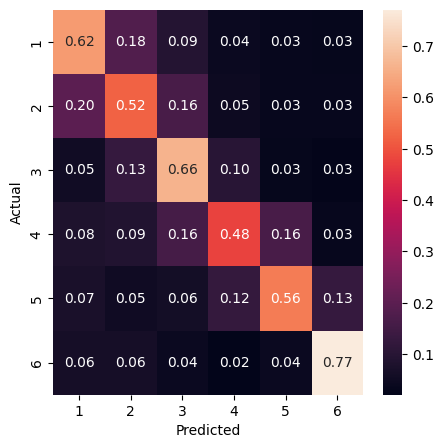

In [ ]:
# @title confusion matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

# model.eval()
# y_true, y_pred = [], []
# img,label=next(iter(test_loader))
# # img=
# with torch.no_grad():
#     # print(img.shape) # [16, 3, 400, 640]
#     img=img.to(device)
#     pimg = model(img)
#     for x, y in test_loader:
#         x, y = x.to(device), y.to(device)
#         pred = model(x)
#         correct += (pred.argmax(1) == y).type(torch.float).sum().item()



def confusion(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    # y_true, y_pred = [], []
    # y_true, y_pred = torch.empty(0), torch.empty(0)
    y_true, y_pred = torch.empty(0, device=device), torch.empty(0, device=device)
    # test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            # print(pred[0])
            # loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            # test_loss += loss_fn(pred, y).item()
            print((pred.argmax(1)==y).sum().item(), pred.argmax(1).tolist(), y.tolist())
            # y_true(pred.argmax(1)), y_pred(y)
            y_pred = torch.cat((y_pred, pred.argmax(1)), 0)
            y_true = torch.cat((y_true, y), 0)
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # test_loss /= num_batches
    # correct /= size
    # should not use weighted rand sampler for test?
    # if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    # return correct, test_loss
    return y_true, y_pred
    # y_true, y_pred = y_true(), y_pred.cpu()
    # cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    # cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # fig, ax = plt.subplots(figsize=(5,5))
    # sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['1','2','3','4','5','6',], yticklabels=['1','2','3','4','5','6',])
    # plt.ylabel('Actual')
    # plt.xlabel('Predicted')
    # plt.show()

# y_true, y_pred = confusion(test_loader, model, loss_fn)

y_true, y_pred = y_true.cpu(), y_pred.cpu()
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['1','2','3','4','5','6',], yticklabels=['1','2','3','4','5','6',])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()




In [ ]:
# pytorch release gpu ram after training
# https://discuss.pytorch.org/t/free-all-gpu-memory-used-in-between-runs/168202/2

torch.cuda.empty_cache()

# correct, test_loss = test(test_loader, model, loss_fn)
# train_lst.extend(train_ls)
# test_lst.append(test_loss)
# acc_lst.append(correct)



In [ ]:
# @title trash

model.eval()
count=0
i=138
rong_lst=[]

while count<20:
    img,label=test_data[i]
    pred=model(img.unsqueeze(0).to(device))
    pred_probab = nn.Softmax(dim=1)(pred)
    y_pred = pred_probab.argmax(1)
    if y_pred.item() != label:
        print("pred: ",y_pred.item(),", actual: ",label)
        # plt.imshow(np.transpose(img, (1, 2, 0)))
        # plt.show()
        imshow(img)
        rong_lst.append(img)
        count+=1
    i+=1


# 20/137 wrong


In [ ]:
print(i)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# print(torch.stack(rong_lst).shape)
# print(len(rong_lst))
# print(rong_lst[0].shape)
imshow(torchvision.utils.make_grid(torch.stack(rong_lst),nrow=4))
